In [116]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import accumulate
import dlc_practical_prologue as prologue

In [0]:
torch.manual_seed(0)
N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def k_fold(data, ind, k):
    n = len(data)
    return data[n * (ind-1)//k:n * ind//k], data[0:n * (ind-1)//k], data[n * ind//k:]

In [0]:




##############################First Model#########################################
#Test error rate 19%
#Convergence 20 epochs

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        
        self.conv1 = nn.Conv2d(2, 32, kernel_size = 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128, 100)
        self.out = nn.Linear(100, 2)
    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        
        x = F.relu(F.max_pool2d(self.conv2(x), stride = 2, kernel_size = 2))
        x = self.bn2(x)
        
        x = F.relu(F.max_pool2d(self.conv3(x), stride = 2, kernel_size = 2))
        x = self.bn3(x)
        
        x = F.relu(self.fc1(x.view(-1,128)))
        x = self.out(x)
        
        return x
    

In [0]:


###############################Second Model#####################################
# Error rate 13-14%
# Convergence fast
# Computationally more expensive 




class NetWeightSharing(nn.Module):
    def __init__(self):
        super(NetWeightSharing, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128, 100)
        
        self.out = nn.Linear(200, 2)
    
    def sharing_layers(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        
        x = F.relu(F.max_pool2d(self.conv2(x), stride = 2, kernel_size = 2))
        x = self.bn2(x)
        
        x = F.relu(F.max_pool2d(self.conv3(x), stride = 2, kernel_size = 2))
        x = self.bn3(x)
        x = F.relu(self.fc1(x.view(-1,128)))
        return x
        
    def forward(self, x):
        
        x1 = self.sharing_layers(x[:,0].unsqueeze(1))
        x2 = self.sharing_layers(x[:,1].unsqueeze(1))
        
        output = torch.cat((x1,x2),1)
        output = self.out(output)
        
        return output
        
        
        
model = NetWeightSharing()

In [0]:


#####################################Third Model###########################################
#Error rate 10.9%




class NetAux_Share(nn.Module):
    def __init__(self):
        super(NetAux_Share, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128, 100)
        
        self.out1 = nn.Linear(100, 10)
        self.out2 = nn.Linear(100, 10)
        
        self.out = nn.Linear(20, 2)
    
    def sharing_layers(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        
        x = F.relu(F.max_pool2d(self.conv2(x), stride = 2, kernel_size = 2))
        x = self.bn2(x)
        
        x = F.relu(F.max_pool2d(self.conv3(x), stride = 2, kernel_size = 2))
        x = self.bn3(x)
        x = F.relu(self.fc1(x.view(-1,128)))
        return x
        
    def forward(self, x):
        
        x1 = self.sharing_layers(x[:,0].unsqueeze(1))
        x2 = self.sharing_layers(x[:,1].unsqueeze(1))
        
        x1 = self.out1(x1)
        x2 = self.out2(x2)
        
        output = torch.cat((x1,x2),1)
        
        output = self.out(output)
        
        return output, x1, x2


In [0]:

################################FULLY CONNECTED NETWORK#################################

class SimpleFCNetwork(nn.Module):
    def __init__(self, h_shapes):
       
        super().__init__()
        self.length = len(h_shapes)
        self.hidden_l = nn.ModuleList()
        for i in range(len(h_shapes)-1):
            self.hidden_l.append(nn.Linear(h_shapes[i], h_shapes[i+1]))
        
        
        self.fc1 = nn.Linear(392, h_shapes[0])
        self.fc3 = nn.Linear(h_shapes[self.length-1], 2)
       
        
    def forward(self, x):
      
  
        x = F.relu(self.fc1(x))
     
        for i in range(self.length-1):
          x = F.relu(self.hidden_l[i](x))
      
        x = F.relu(self.fc3(x))
       
        return x



In [0]:
################################FULLY CONNECTED NETWORK WITH AUX LOSS#################################


class FCAux(nn.Module):
    def __init__(self, h_shapes):
       
        super().__init__()
        self.length = len(h_shapes)
        self.hidden_l = nn.ModuleList()
        for i in range(len(h_shapes)-1):
            self.hidden_l.append(nn.Linear(h_shapes[i], h_shapes[i+1]))
        
       
        self.fc1 = nn.Linear(392, h_shapes[0])
        self.fc3 = nn.Linear(h_shapes[self.length-1], 2)
        self.fc4 = nn.Linear(392, 20)
        
    def forward(self, x):
  
        y = x
        x = F.relu(self.fc1(x))
        y = F.relu(self.fc4(y))
        for i in range(self.length-1):
          x = F.relu(self.hidden_l[i](x))
        y = y.view(-1,2,10)
        x = F.relu(self.fc3(x))
       
        return x,y



In [0]:

################################PRECISION-RECALL CURVE#################################
def precision_recall(target, pred):
  
  target = [True if x else False for x in target]
  sorted_ind = sorted(range(len(list(pred))), key=lambda k: list(pred)[k])
  sorted_ind.reverse()

  pred = [pred[i] for i in sorted_ind]

  target = [target[i] for i in sorted_ind]

  uniqs = list(set(list(pred)))
  uniqs.sort(reverse=True)
  
  indexes = [list(pred).index(x) for x in uniqs]

  t = [1 if x else 0 for x in target]
  tp_accum = list(accumulate(t))
  
  
  tps = [tp_accum[i] for i in indexes]

  ones = [1]*(len(target))
  fp_accum = list(accumulate([a_i - b_i for a_i, b_i in zip(ones, t)]))
  fps = [1+t-tp for t,tp in zip(indexes,tps)]

  
  precision = [x/(x + y) if x+y else 0 for x,y in zip(tps,fps)]
  recall =  [x/tps[-1] if tps[-1] else 0 for x in tps]

  thresholds = [pred[i] for i in indexes]
  
  last_ind = len(tps)-2
  sl = slice(last_ind, None, -1)

  pre = precision[sl]
  pre.append(1.0)
  rec = recall[sl]
  rec.append(0.0)
  return pre, rec, thresholds[sl]


In [0]:
################################ROC CURVE#################################

def roc_true(target, pred):
  
  target = [True if x else False for x in target]
  sorted_ind = sorted(range(len(list(pred))), key=lambda k: list(pred)[k])
  sorted_ind.reverse()
 
  pred = [pred[i] for i in sorted_ind]

  target = [target[i] for i in sorted_ind]

  uniqs = list(set(list(pred)))
  uniqs.sort(reverse=True)
  
  indexes = [list(pred).index(x) for x in uniqs]
  

  t = [1 if x else 0 for x in target]
  tp_accum = list(accumulate(t))
  
  
  tps = [tp_accum[i] for i in indexes]

  ones = [1]*(len(target))
  fp_accum = list(accumulate([a_i - b_i for a_i, b_i in zip(ones, t)]))
  fps = [1+t-tp for t,tp in zip(indexes,tps)]

  thresholds = [pred[i] for i in indexes]

  thresholds.insert(0, thresholds[0] + 1)
  tps.insert(0, 0)
  fps.insert(0, 0)
  fpr = [i/fps[-1] for i in fps]
  tpr = [i/tps[-1] for i in tps]

  return fpr, tpr, thresholds


In [0]:


################################Training Function#################################
def training_model(train_input, train_target, model, batch, lr):
    model.to(device)
    train_input.to(device)
    train_target.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    for b in range(0, train_input.size(0), batch):
        output = model(train_input.narrow(0, b, batch).to(device))            
        loss = criterion(output, train_target.narrow(0, b, batch).to(device))
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss 


def compute_nb_errors(model, data_input, data_target, batch):
    model.to(device)
    data_input.to(device)
    data_target.to(device)
    nb_data_errors = 0

    for b in range(0, data_input.size(0), batch):
        output = model(data_input.narrow(0, b, batch).to(device))
        _, predicted_classes = torch.max(output, 1)
        for k in range(batch):
            if data_target[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1
    return nb_data_errors

##########################Train Aux Function########################################
    
def training_aux(CNNFlag, train_input, train_target, train_classes, model, batch, lr):
    model.to(device)
    train_input.to(device)
    train_target.to(device)
    train_classes.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    Binary_Criterion = nn.CrossEntropyLoss()
    Aux_Criterion = nn.CrossEntropyLoss()
    total_loss_aux = 0
    total_loss_bin = 0
    final_total_loss = 0
    for b in range(0, train_input.size(0), batch):
      if CNNFlag:
        output, aux1, aux2 = model(train_input.narrow(0, b, batch).to(device))
      else:
        output, aux = model(train_input.narrow(0, b, batch).to(device))
      target_classes = train_classes.narrow(0, b, batch).to(device)
      target_comparison = train_target.narrow(0, b, batch).to(device)
      if CNNFlag:
        aux_loss = Aux_Criterion(aux1, target_classes[:,0].to(device)) + Aux_Criterion(aux2, target_classes[:,1].to(device))
      else:
        aux_loss = Aux_Criterion(aux[:,0], target_classes[:,0].to(device)) + Aux_Criterion(aux[:,0], target_classes[:,1].to(device))
      binary_loss = Binary_Criterion(output, target_comparison)
      final_loss = 0.7*binary_loss + 0.3*aux_loss
      model.zero_grad()
      final_loss.backward()
      optimizer.step()
      total_loss_aux += aux_loss
      total_loss_bin += binary_loss
      final_total_loss += final_loss
    return final_total_loss, total_loss_aux, total_loss_bin

def compute_nb_errors_aux(CNNFlag, model, data_input, data_target, batch):
    model.to(device)
    data_input.to(device)
    data_target.to(device)
    
    nb_data_errors = 0

    for b in range(0, data_input.size(0), batch):
      if CNNFlag:
        output,_,_ = model(data_input.narrow(0, b, batch).to(device))
      else: 
         output,_ = model(data_input.narrow(0, b, batch).to(device))
      _, predicted_classes = torch.max(output, 1)
      for k in range(batch):
          if data_target[b + k] != predicted_classes[k]:
              nb_data_errors = nb_data_errors + 1
    return nb_data_errors




In [0]:
def train_until_convergence(CNNFlag, AuxFlag, model, training_data, training_target, training_classes, batch, l):
  prev_loss = 999999
  #TRAIN UNTIL CINVERGENCE
  epochs = 0
  while(True):
    epochs += 1
    if not AuxFlag:
      cur_loss = training_model(training_data, training_target, model, batch, l)
    else:
      cur_loss, _, _ = training_aux(CNNFlag, training_data, training_target, training_classes, model, batch, l)
    
    
    if(abs(prev_loss - cur_loss) <= 0.001):
      break
    prev_loss = cur_loss
  return epochs

In [0]:
def report_error(CNNFlag, AuxFlag, model, test_data, test_target, batch):
  error = 0
  if not AuxFlag: 
    error = compute_nb_errors(model, test_data,test_target, batch)
  else:
    error = compute_nb_errors_aux(CNNFlag, model, test_data,test_target, batch)
  return error


In [0]:
################################HYPERPARAMETER TUNING WITH CROSSVALIDATION#################################
def cross_validation_tuning(CNNFlag, AuxFlag,train_data, train_target, training_classes, k, lr, batches, neurons = None):
  err_min = 999999

  #TUNING NUMBER OF BATCHES
  for batch in batches:
    #TUNING LEARNING RATE
    for l in lr:
      #CHECKING IF TUNING IS FIR A CNN NETWORK
      if(not CNNFlag):
        #TUNING FOR NUMBER OF HIDDEN LAYERS FOR FC NETWORK
        for neuron_count in neurons:
          error = 0
          #CROSS VALIDATION
          for i in range(1, k + 1): 
            if not AuxFlag:
              model = SimpleFCNetwork(neuron_count)
            else:
              model = FCAux(neuron_count)
            #FOLDING THE DATA
            test_data, train_1_data, train_2_data = k_fold(train_data, i, k)
            test_target, train_1_target, train_2_target = k_fold(train_target, i, k)
            training_data = torch.cat((train_1_data,train_2_data),0)
            training_target = torch.cat((train_1_target,train_2_target),0)
            prev_loss = 999999
            #TRAIN UNTIL CINVERGENCE
            train_until_convergence(CNNFlag, AuxFlag, model, training_data, training_target, train_classes, batch, l)

            error += report_error(CNNFlag, AuxFlag, model, test_data, test_target, batch)
          error /= k
          
          if error < err_min:
            err_min = error
            l_min = l
            batch_min = batch
            neruron_min =  neuron_count if neurons else None
      #NUMBER OF HIDDEN LAYERS IS NOT TUNED FOR CNN
      else:
       
        error = 0
        #CROSS VALIDATION
        for i in range(1, k + 1): 
          #FOLDING THE DATA
          test_data, train_1_data, train_2_data = k_fold(train_data, i, k)
          test_target, train_1_target, train_2_target = k_fold(train_target, i, k)
          training_data = torch.cat((train_1_data,train_2_data),0)
          training_target = torch.cat((train_1_target,train_2_target),0)
          if not AuxFlag:
            model = NetWeightSharing()
          else:
            model = NetAux_Share()
          prev_loss = 999999
          #TRAIN UNTIL CONVERGENCE
          train_until_convergence(CNNFlag, AuxFlag, model, training_data, training_target, train_classes, batch, l)
 

          error += report_error(CNNFlag, AuxFlag, model, test_data, test_target, batch)
        error /= k

       
        #TAKE THE HYPERPARAMETERS WITH MINIMAL ERROR
        if error < err_min:
          err_min = error
          l_min = l
          batch_min = batch
          neruron_min =  neuron_count if neurons else None
  return err_min, l_min, batch_min, neruron_min
  

In [0]:
def get_predictions(CNNFlag, AuxFlag, model, test_input):
  if not AuxFlag:
    output = model(test_input.to(device))
  elif CNNFlag:
    output, _, _ = model(test_input.to(device))
  else:
    output, _ = model(test_input.to(device))

  m = nn.Softmax()
  probs = m(output)
  return probs[:, 1]

  

In [0]:
def plot_roc_curve(test_target, predictions):
  fpr, tpr, _  = (roc_true(test_target, predictions))
  plt.plot(fpr, tpr, marker='.', label='mlp')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()


In [0]:
def  plot_precision_recall_curve(test_target, predictions):
  lr_recall, lr_precision, _  = (precision_recall(test_target, predictions))
  plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.show()


In [0]:
err, otpimum_lr, batch_size, neuron_size = cross_validation_tuning(True, False, train_input, train_target, train_classes,10,[0.1,0.05,0.01],[20, 100, 50])
print(err, otpimum_lr, batch_size, neuron_size)

In [0]:
#############################Training Part###############################

model = NetWeightSharing()
number_of_epochs = train_until_convergence(True, False, model, train_input, train_target, train_classes, batch_size, otpimum_lr)
print("number of epochs until convergence", number_of_epochs)

predictions = get_predictions(True, False,model, test_input)

plot_precision_recall_curve(test_target.tolist(), torch.flatten(predictions).tolist())
plot_roc_curve(test_target.tolist(), torch.flatten(predictions).tolist())



In [109]:
err, otpimum_lr, batch_size, neuron_size = cross_validation_tuning(True, True, train_input, train_target, train_classes,10,[0.1,0.05, 0.01],[20, 100, 50])
print(err, otpimum_lr, batch_size, neuron_size)

here
lr: 0.1
rarar 20.6
lr: 0.05
rarar 23.2
lr: 0.01
rarar 25.5
lr: 0.1
rarar 21.5
lr: 0.05
rarar 20.9
lr: 0.01
rarar 25.6
20.6 0.1 100 None


number of epochs until convergence 60


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


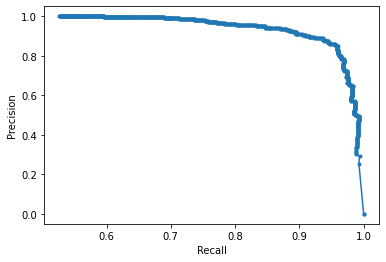

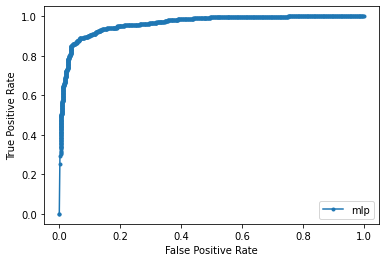

In [110]:
model = NetAux_Share()
number_of_epochs = train_until_convergence(True, True, model, train_input, train_target, train_classes, batch_size, otpimum_lr)
print("number of epochs until convergence", number_of_epochs)

predictions = get_predictions(True, True, model,test_input)

plot_precision_recall_curve(test_target.tolist(), torch.flatten(predictions).tolist())
plot_roc_curve(test_target.tolist(), torch.flatten(predictions).tolist())

In [0]:
train_input_first_approach =  torch.zeros(size = (1000,392))
test_input_first_approach = torch.zeros(size = (1000,392))

for i in range(train_input.size(0)):
  
    train_input_first_approach[i]  = torch.cat((torch.flatten(train_input[i,0]),torch.flatten(train_input[i,1])),0)
    test_input_first_approach[i] = torch.cat((torch.flatten(test_input[i,0]),torch.flatten(test_input[i,1])),0)

In [112]:
err, otpimum_lr, batch_size, neuron_size  = cross_validation_tuning(False, False, train_input_first_approach, train_target, train_classes,10,[0.1,0.005],[100, 50],[[200,50,10],[150,100],[100]])
print(err,otpimum_lr, batch_size, neuron_size)

here
rarar 53.9
rarar 55.1
rarar 55.1
rarar 25.8
rarar 54.9
rarar 55.1
rarar 55.1
rarar 55.1
rarar 55.1
rarar 29.2
rarar 52.1
rarar 55.1
25.8 0.005 100 [200, 50, 10]


number of epochs until convergence 54


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


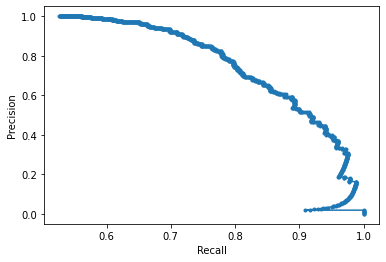

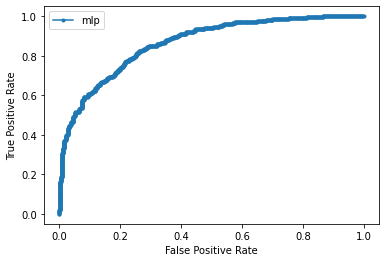

In [113]:
model = SimpleFCNetwork(neuron_size)
number_of_epochs = train_until_convergence(False, False, model, train_input_first_approach, train_target, train_classes, batch_size, otpimum_lr)
print("number of epochs until convergence", number_of_epochs)

predictions = get_predictions(False, False, model, test_input_first_approach)

plot_precision_recall_curve(test_target.tolist(), torch.flatten(predictions).tolist())
plot_roc_curve(test_target.tolist(), torch.flatten(predictions).tolist())

In [114]:
err, otpimum_lr, batch_size, neuron_size  = cross_validation_tuning(False, True, train_input_first_approach, train_target, train_classes,10,[0.1,0.005],[100, 50],[[200,50,10],[150,100],[100]])
print(err,otpimum_lr, batch_size, neuron_size)

here
rarar 55.1
rarar 55.1
rarar 55.1
rarar 26.8
rarar 55.1
rarar 55.1
rarar 55.1
rarar 55.1
rarar 55.1
rarar 23.3
rarar 48.4
rarar 55.1
23.3 0.005 50 [200, 50, 10]


number of epochs until convergence 80


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


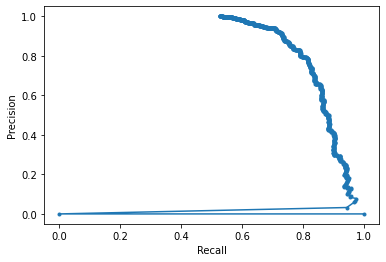

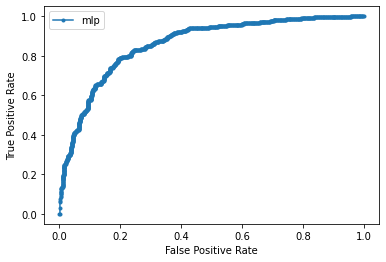

In [115]:
model = FCAux(neuron_size)
number_of_epochs = train_until_convergence(False, True, model, train_input_first_approach, train_target, train_classes, batch_size, otpimum_lr)
print("number of epochs until convergence", number_of_epochs)

predictions = get_predictions(False, True, model, test_input_first_approach)

plot_precision_recall_curve(test_target.tolist(), torch.flatten(predictions).tolist())
plot_roc_curve(test_target.tolist(), torch.flatten(predictions).tolist())